# Agent for Drug Discovery

## Setting up the environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import pathlib

from decimal import Decimal
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from typing import Annotated, Any, Dict, List, Sequence, Tuple, TypedDict

import time
from datetime import datetime

import threading
from queue import Queue
import signal

import boto3
from botocore.config import Config
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.batchfold_target import BatchFoldTarget
from batchfold.jackhmmer_job import JackhmmerJob
from batchfold.alphafold2_job import AlphaFold2Job
from batchfold.utils import utils

from langchain_aws import ChatBedrockConverse
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import graph, END, StateGraph
from langchain.prompts import ChatPromptTemplate

from Bio import SeqIO

# import local modules
dir_current = os.path.abspath("")
dir_parent = os.path.dirname(dir_current)
if dir_parent not in sys.path:
    sys.path.append(dir_parent)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.3)
  from scipy.sparse import csr_matrix, issparse


In [3]:
# set region and model name
aws_region = "us-west-2"
model_name = "anthropic.claude-3-5-sonnet-20241022-v2:0"

# Set bedrock configs
bedrock_config = Config(
    connect_timeout=300, read_timeout=300, retries={"max_attempts": 10}
)

# Create a bedrock runtime client
bedrock_rt = boto3.client(
    "bedrock-runtime", region_name=aws_region, config=bedrock_config
)

# make llm
def make_llm(model=model_name, temperature=0, max_tokens=None):
    llm = ChatBedrockConverse(
        client=bedrock_rt,
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return llm

In [4]:
# Create AWS clients
boto_session = boto3.session.Session()

batch_environment = BatchFoldEnvironment(boto_session=boto_session)

S3_BUCKET = batch_environment.default_bucket
# print(f" S3 bucket name is {S3_BUCKET}")

In [5]:
# setting dynamoDB
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('Experiment')

In [6]:
batch_environment.list_job_queue_names()

['CPUOnDemandJobQueue', 'CPUSpotJobQueue', 'G4dnJobQueue']

## Agent using LangGraph

### Define agent state

In [7]:
class AgentState(TypedDict):
    messages: Sequence[HumanMessage | AIMessage]
    next_step: str | None
    files: Dict[str, Any]
    current_response: str | None
    proteins: BatchFoldTarget | None

### Define route function that decides next action

In [8]:
def route(state: AgentState) -> Dict[str, str]:
    
    messages = state["messages"]
    
    if messages[-1].content.lower() in ["종료"]:
        return {"next_step": "terminate"}
    
    # 라우팅을 위한 프롬프트 템플릿
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a smart AI research assistant that helps users analyze various types of data and answer questions in drug discovery.
        Based on the user's input, you need to decide which action to take:
        1. "basic_qa" - Use your general knowledge to answer basic questions
        2. "data_analysis" - Analyze data from provided files (CSV, etc.)
        3. "tool_use" - Use external tools like AlphaFold for specific tasks
        
        Respond with ONLY ONE of three options: "basic_qa", "data_analysis", or "tool_use".
        """),
        ("human", "Here's the conversation history and latest message. Decide what action to take next:\n{input}")
    ])
    
    llm = make_llm()
    response = llm.invoke(prompt.format_messages(input=messages[-1].content))
    action = response.content.strip()
    
    # 상태 업데이트
    new_state = state.copy()
    new_state["next_step"] = action
    
    return new_state

### Define a function to handle basic QAs

In [9]:
def handle_basic_qa(state: AgentState) -> AgentState:

    messages = state["messages"]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a knowledgeable AI assistant for drug discovery. Answer the question based on your general knowledge."),
        ("human", "{input}")
    ])
    
    llm = make_llm()
    response = llm.invoke(prompt.format_messages(input=messages[-1].content))
    
    new_state = state.copy()
    new_state["current_response"] = response.content
    return new_state

### Define a function to handle data analysis task from input files

In [10]:
def handle_data_analysis(state: AgentState) -> AgentState:
    
    messages = state["messages"]
    files = state["files"]
    
    required_files = {"training.csv", "test.csv"}
    missing_files = required_files - files.keys()
    
    if missing_files:
        raise FileNotFoundError(f"필요한 파일이 없습니다: {', '.join(missing_files)}")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a data analysis expert in the field of drug discovery. 
        Please learn the pattern between input molecules and output in the training data.
        Then, using your basic knowledge and waht you learned from the training data, predict output for the molecules in the test data.
        Please generate only the requested output, without any additional explanations, comments, or suggestions.
        Please provide your response in a CSV format with columns: input,output,property name.
        Each row should contain: SMILES string, predicted property, and the name of property as in the training data.
        """),
        ("human", """Training data: {training_data}\n
        Test data: {test_data}\n
        """)
    ])
    
    llm = make_llm()
    
    response = llm.invoke(prompt.format_messages(
        input = messages[-1].content,
        training_data = files['training.csv'],
        test_data = files['test.csv'],
        )
    )
    
    def _parse_claude_response(response: str) -> List[Dict]:
        """
        Claude의 응답에서 분자와 예측된 용해도를 추출
        응답 형식은 자유로울 수 있으므로, 숫자와 SMILES를 추출하는 로직이 필요할 수 있습니다
        """
        # 여기에 응답 파싱 로직을 구현
        # 예시: 응답이 CSV 형식이라고 가정
        try:
            from io import StringIO
            df = pd.read_csv(StringIO(response))
            return df.to_dict('records')
        except:
            # CSV 파싱이 실패할 경우의 대체 로직
            # 정규표현식이나 다른 파싱 방법을 사용할 수 있습니다
            pass
    
    def _save_predictions_to_csv(predictions: List[Dict], filename: str = "molecule/test_prediction.csv"):
        """예측 결과를 CSV 파일로 저장"""
        df = pd.DataFrame(predictions)
        df.to_csv(filename, index=False)
        print(f"예측 결과가 {filename}에 저장되었습니다.")
    
    predictions = _parse_claude_response(response.content)
    _save_predictions_to_csv(predictions)
    
    new_state = state.copy()
    new_state["current_response"] = response
    return new_state

##### Correlation plot for the reulsts

In [11]:
def load_and_prepare_data(previous_file, current_file):
    """두 CSV 파일을 읽고 데이터를 준비"""
    df_prev = pd.read_csv(previous_file)
    df_curr = pd.read_csv(current_file)
    
    # SMILES를 기준으로 데이터 병합
    merged_df = pd.merge(df_prev, df_curr, 
                        on='input', 
                        suffixes=('_previous', '_current'))
    
    # 용해도 값을 float로 변환
    merged_df['output_previous'] = merged_df['output_previous'].astype(float)
    merged_df['output_current'] = merged_df['output_current'].astype(float)
    
    return merged_df

def create_correlation_plot(merged_df, output_file='correlation_plot.png'):
    """상관관계 플롯 생성"""
    # 피어슨 상관계수 계산
    correlation = stats.pearsonr(merged_df['output_previous'], 
                               merged_df['output_current'])
    r_squared = correlation[0]**2
    
    # 플롯 생성
    plt.figure(figsize=(10, 8))
    
    # 산점도
    sns.scatterplot(data=merged_df, 
                   x='output_previous', 
                   y='output_current', 
                   alpha=0.6)
    
    # 대각선 추가 (y=x 라인)
    min_val = min(merged_df['output_previous'].min(), 
                 merged_df['output_current'].min())
    max_val = max(merged_df['output_previous'].max(), 
                 merged_df['output_current'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', label='y=x')
    
    # 회귀선 추가
    sns.regplot(data=merged_df, 
                x='output_previous', 
                y='output_current', 
                scatter=False, 
                color='blue', 
                line_kws={'label': f'Regression line\nR² = {r_squared:.3f}'})
    
    # 그래프 스타일링
    plt.title('Correlation between Previous and Current Solubility Predictions', 
             fontsize=14, pad=20)
    plt.xlabel('Previous Predictions', fontsize=12)
    plt.ylabel('Current Predictions', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(merged_df['output_previous'], 
                                    merged_df['output_current']))
    
    # 통계 정보 추가
    stats_text = (f'Statistics:\n'
                 f'R² = {r_squared:.3f}\n'
                 f'RMSE = {rmse:.3f}\n'
                 f'Pearson r = {correlation[0]:.3f}\n'
                 f'p-value = {correlation[1]:.3e}')
    
    plt.text(0.05, 0.95, stats_text, 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top', 
             fontsize=10)
    
    # 그래프 저장
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"상관관계 플롯이 {output_file}에 저장되었습니다.")
    
    return r_squared, rmse, correlation

### Define tools for drug discovery

In [12]:
# alphafold
def alphafold_protein_structure_prediction(state: AgentState) -> AgentState:

    try:
        for fasta in state["proteins"]:
            target_id, sequence = fasta.id, str(fasta.seq)
            try:
                description = fasta.description
            except:
                description = "None"
            target_id = target_id.split("_")[0]
            target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
            target.add_sequence(
                seq_id=target_id,
                seq=sequence,
                description=description,
            )

            job_name = target.target_id + "_JackhmmerJob_" + datetime.now().strftime("%Y%m%d%s")
            jackhmmer_job = JackhmmerJob(
                job_name=job_name,
                target_id=target.target_id,
                fasta_s3_uri=target.get_fasta_s3_uri(),
                output_s3_uri=target.get_msas_s3_uri(),
                boto_session=boto_session,
                cpu=16,
                memory=31,
            )
            jackhmmer_submission = batch_environment.submit_job(
                jackhmmer_job, job_queue_name="CPUOnDemandJobQueue"
            )

            job_name = target.target_id + "_AlphaFold2Job_" + datetime.now().strftime("%Y%m%d%s")
            alphafold2_job = AlphaFold2Job(
                job_name=job_name,
                target_id=target.target_id,
                fasta_s3_uri=target.get_fasta_s3_uri(),
                msa_s3_uri=target.get_msas_s3_uri(),
                output_s3_uri=target.get_predictions_s3_uri() + "/" + job_name,
                boto_session=boto_session,
                cpu=4,
                memory=15,  # Why not 16? ECS needs about 1 GB for container services
                gpu=1,
            )
            alphafold2_submission = batch_environment.submit_job(
                alphafold2_job, job_queue_name="G4dnJobQueue", depends_on=[jackhmmer_submission]
            )

        new_state = state.copy()
        new_state["current_response"] = f"All jobs are submitted successfully!.\nYour result will be saved in {target.get_predictions_s3_uri() + '/' + job_name}"
    
    except Exception as e:
        new_state["current_response"] = f"Some jobs are failed!\n에러 메시지: {str(e)}"

    return new_state

In [13]:
TOOLS = [
    {
        "name": "alphafold_protein_structure_prediction",
        "function_name": alphafold_protein_structure_prediction,
        "description": "Predict protein structure using Multiple Sequence Alignment",
        "input_file": "fasta"
    }
]

### Define a function to handle tools 

In [14]:
def tool_use(state: AgentState) -> AgentState:
    messages = state["messages"]
    
    tools_prompt = ""
    tools_types = ""
    tools_num = len(TOOLS)
    for index, tool in enumerate(TOOLS):
        tools_prompt += f'{index+1}. "{tool["name"]}" - {tool["description"]} '
        
        if index < tools_num-1:
            tools_types += f'"{tool["name"]}'
            tools_types += ', '
        else:
            tools_types += "or "
            tools_types += f'"{tool["name"]}'
            
    _nums = {1:'one',
        2:'two',
        3:'three',
        4:'four',
        5:'five',
        6:'six',
        7:'seven',
        8:'eight',
        9:'nine'}
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are an AI assistant that can use external tools.
        Based on the user's input, you need to decide which action to take:
        
        
        Currently available tools: 
        {tools_prompt}
        
        Respond with ONLY ONE of {_nums[tools_num]} options: {tools_types}."""),
        ("human", "Here's the conversation history and latest message. Decide what action to take next:\n{input}")
    ])
    
    llm = make_llm()
    response = llm.invoke(prompt.format_messages(input=messages[-1].content))
    
    action = response.content.strip()
    
    # 상태 업데이트
    new_state = state.copy()
    new_state["next_step"] = action
    return new_state

### Define a graph

In [15]:
def create_agent_graph():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("route", route)
    workflow.add_node("basic_qa", handle_basic_qa)
    workflow.add_node("data_analysis", handle_data_analysis)
    workflow.add_node("tool_use", tool_use)
    
    for tool in TOOLS:
        workflow.add_node(tool["name"], tool["function_name"])
    
    # Add edges
    workflow.set_entry_point("route")
    
    workflow.add_conditional_edges(
        "route",
        lambda x: x["next_step"],
        {
            "basic_qa": "basic_qa",
            "data_analysis": "data_analysis",
            "tool_use": "tool_use",
            "end": END
        },
    )
    
    workflow.add_conditional_edges(
        "tool_use", 
        lambda x: x["next_step"],
        dict((tool["name"], tool["name"]) for tool in TOOLS),
    )
    
    # 응답 생성 엣지
    workflow.add_edge("basic_qa", END)
    workflow.add_edge("data_analysis", END)
    
    for tool in TOOLS:
        workflow.add_edge(tool["name"], END)
    
    return workflow.compile()

### Define agent class

In [16]:
class DrugDiscoveryAssistantAgent:
    def __init__(self):
        self.graph = create_agent_graph()
        self.state = {
            "messages": [],
            "next_step": None,
            "files": {},
            "current_response": None,
        }
        
    def _convert_floats_to_decimals(self, obj):
        """
        Convert float values to Decimal for DynamoDB compatibility
        """
        if isinstance(obj, dict):
            return {k: self._convert_floats_to_decimals(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._convert_floats_to_decimals(i) for i in obj]
        elif isinstance(obj, float):
            return Decimal(str(obj))
        return obj
    
    def add_csv_file(self, file_name: str):
        """
        Add CSV data to LLM's input

        Args:
            file_name (str): Path to the CSV file
        """
        df = pd.read_csv(f"molecule/{file_name}")
        self.state["files"][file_name] = df.to_string(index=False)
        
    def add_and_save_csv_file(self, file_name: str, experiment_name: str=None, user_name: str="hasunyu"):
        """
        Upload CSV data to DynamoDB

        Args:
            csv_file_path (str): Path to the CSV file
            experiment_name (str, optional): Custom experiment ID. If not provided, generates one
        """
        df = pd.read_csv(f"molecule/{file_name}")
        self.state["files"][file_name] = df.to_string(index=False)

        data = df.to_dict('records')
        
        data = self._convert_floats_to_decimals(data)
        
        current_date = datetime.now().strftime("%Y%m%d%s")
        
        if not experiment_name:
            experiment_id = f"Experiment_{user_name}_{current_date}"
        else:
            experiment_id = f"{experiment_name}_{user_name}_{current_date}"
            
        experiment_item = {
            'ExperimentID': experiment_id,
            'Data': data,
        }
        
        try:
            response = table.put_item(Item=experiment_item)
            print(f"Successfully uploaded experiment {experiment_id} to DynamoDB")

        except Exception as e:
            print(f"Error uploading to DynamoDB: {str(e)}")
            raise        
    
    def load_csv_file(self, experiment_id: str):
        """
        Retrieve experiment data from DynamoDB using experiment_id

        Args:
            experiment_id (str): The ID of the experiment to retrieve

        Returns:
            dict: The experiment data including ExperimentID, Data, and Type
            None: If the experiment is not found
        """
        try:
            # Get item from DynamoDB
            response = table.get_item(
                Key={
                    'ExperimentID': experiment_id
                }
            )

            # Check if item exists
            if 'Item' in response:
                experiment = response['Item']
                print(f"Successfully retrieved experiment {experiment_id}")

                # Convert the data to pandas DataFrame for easier handling
                if 'Data' in experiment:
                    data = [{k: float(v) if isinstance(v, Decimal) else v 
                            for k, v in item.items()} 
                           for item in experiment['Data']]
                    df = pd.DataFrame(data)
                
                    self.state["files"]['training.csv'] = df.to_string(index=False)
            else:
                print(f"No experiment found with ID: {experiment_id}")

        except Exception as e:
            print(f"Error retrieving experiment: {str(e)}")
            raise
    
    @staticmethod
    def list_experiments():
        """
        List all experiments stored in DynamoDB

        Returns:
            list: List of experiment IDs
        """
        try:
            # Scan the table
            response = table.scan(
                ProjectionExpression='ExperimentID',
            )

            experiments = response['Items']

            # Handle pagination if there are more items
            while 'LastEvaluatedKey' in response:
                response = table.scan(
                    ProjectionExpression='ExperimentID',
                    ExclusiveStartKey=response['LastEvaluatedKey']
                )
                experiments.extend(response['Items'])

            # Sort experiments by ID
            experiments.sort(key=lambda x: x['ExperimentID'])

            # Print experiments
            print("\nStored Experiments:")
            print("-" * 50)
            print(f"{'ExperimentID':<30} {'Type':<20}")
            print("-" * 50)
            for exp in experiments:
                print(f"{exp['ExperimentID']:<30}")

            return experiments

        except Exception as e:
            print(f"Error listing experiments: {str(e)}")
            raise
        
    def add_protein(self, file_name: str):
        """
        Load fasta sequences from the file
        
        Args:
            file_name (str): Path to the fasta file
        """
        fasta_sequences = SeqIO.parse(open(f"protein/{file_name}"),"fasta")
        self.state["proteins"] = fasta_sequences
        
    def chat(self, message: str):
        """
        Process user message and update the conversation state.
    
        Args:
            message (str): Input message string from the user

        Returns:
            dict: State object containing the updated conversation state
        """
        self.state["messages"].append(HumanMessage(content=message))
        self.state = self.graph.invoke(self.state)
        return self.state

#### Prompt examples
`1. EGFR 단백질의 기본 정보를 알려줘.` \
`2.1. 첨부한 "train.csv" 파일의 정보와 너의 기본 지식을 바탕으로 "test.csv" 파일에 있는 분자들의 특성을 예측해줘.` \
`2.2. DynamoDB에 저장된 "train.csv" 파일의 정보와 너의 기본 지식을 바탕으로 "test.csv" 파일에 있는 분자들의 특성을 예측해줘` \
`3. 첨부한 파일의 단백질의 구조를 예측해줘.`

### Senario 1

In [17]:
agent = DrugDiscoveryAssistantAgent()

In [18]:
# user_input = agent.input_handler.get_input("User: ")
user_input = "EGFR 단백질의 기본 정보를 알려줘."

In [19]:
response = agent.chat(user_input)

In [20]:
response

{'messages': [HumanMessage(content='EGFR 단백질의 기본 정보를 알려줘.', additional_kwargs={}, response_metadata={})],
 'next_step': 'basic_qa',
 'files': {},
 'current_response': 'EGFR (Epidermal Growth Factor Receptor)에 대한 기본 정보를 알려드리겠습니다:\n\n1. 기본 특성\n- 세포막 표면에 존재하는 수용체 타이로신 키나아제(RTK)\n- 170 kDa 크기의 막관통 단백질\n- ErbB/HER 패밀리에 속함\n\n2. 구조\n- 세포외 도메인: 리간드 결합 부위\n- 막관통 도메인\n- 세포내 도메인: 티로신 키나아제 활성을 가짐\n\n3. 주요 기능\n- 세포 증식, 생존, 분화, 이동 조절\n- 상처 치유\n- 조직 항상성 유지\n\n4. 활성화 기전\n- EGF 등의 리간드 결합\n- 수용체 이합체화\n- 티로신 키나아제 활성화\n- 하위 신호전달 경로 활성화\n\n5. 임상적 중요성\n- 여러 암종에서 과발현/변이 발견\n- 폐암, 대장암, 유방암 등의 주요 표적\n- EGFR 표적 치료제 개발의 중요 타겟\n\n6. 대표적인 EGFR 표적 약물\n- 게피티니브(Gefitinib)\n- 얼로티닙(Erlotinib)\n- 세툭시맙(Cetuximab)'}

### Senario 2

#### From uploaded files

In [21]:
agent = DrugDiscoveryAssistantAgent()

In [22]:
user_input = '첨부한 "train.csv" 파일의 정보와 너의 기본 지식을 바탕으로 "test.csv" 파일에 있는 분자들의 특성을 예측해줘'

In [23]:
agent.add_and_save_csv_file("training.csv", experiment_name="Solubility_Training")
agent.add_csv_file("test.csv")

Successfully uploaded experiment Solubility_Training_hasunyu_202411191731985180 to DynamoDB


In [24]:
response = agent.chat(user_input)

예측 결과가 molecule/test_prediction.csv에 저장되었습니다.


상관관계 플롯이 correlation_plot.png에 저장되었습니다.


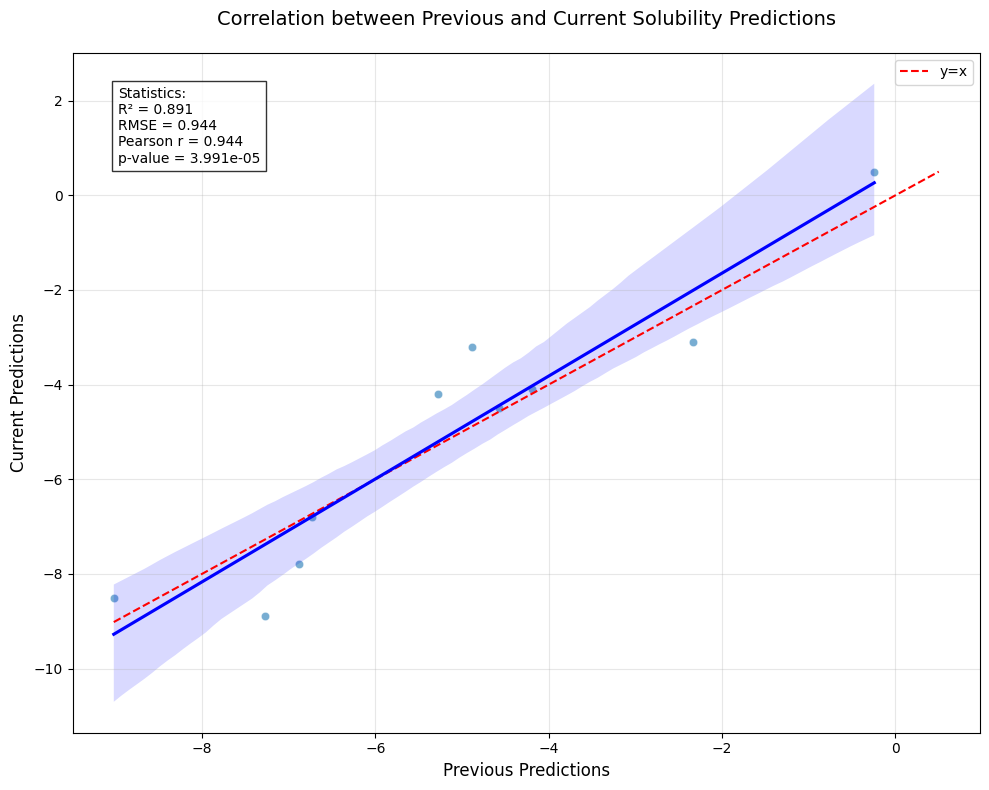

In [25]:
previous_file = 'molecule/test_gt.csv'
current_file = 'molecule/test_prediction.csv'
    
# 데이터 로드 및 전처리
merged_df = load_and_prepare_data(previous_file, current_file)
    
# 상관관계 플롯 생성 및 통계 계산
r_squared, rmse, correlation = create_correlation_plot(merged_df)

#### From files in DynamoDB

In [26]:
agent = DrugDiscoveryAssistantAgent()

In [27]:
agent.list_experiments()


Stored Experiments:
--------------------------------------------------
ExperimentID                   Type                
--------------------------------------------------
Solubility_Training_hasunyu_202411141731565803
Solubility_Training_hasunyu_202411141731565862
Solubility_Training_hasunyu_202411151731661773
Solubility_Training_hasunyu_202411151731661889
Solubility_Training_hasunyu_202411171731883092
Solubility_Training_hasunyu_202411171731883803
Solubility_Training_hasunyu_202411171731884021
Solubility_Training_hasunyu_202411181731888850
Solubility_Training_hasunyu_202411181731889053
Solubility_Training_hasunyu_202411181731889119
Solubility_Training_hasunyu_202411181731889410
Solubility_Training_hasunyu_202411181731889844
Solubility_Training_hasunyu_202411181731889899
Solubility_Training_hasunyu_202411181731890028
Solubility_Training_hasunyu_202411181731903378
Solubility_Training_hasunyu_202411181731903746
Solubility_Training_hasunyu_202411191731977075
Solubility_Training_hasuny

[{'ExperimentID': 'Solubility_Training_hasunyu_202411141731565803'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411141731565862'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411151731661773'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411151731661889'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411171731883092'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411171731883803'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411171731884021'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731888850'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731889053'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731889119'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731889410'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731889844'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731889899'},
 {'ExperimentID': 'Solubility_Training_hasunyu_202411181731890028'},
 {'ExperimentID': 'Solubility_Trai

In [28]:
agent.load_csv_file("Solubility_Training_hasunyu_202411151731661889")
agent.add_csv_file("test.csv")

Successfully retrieved experiment Solubility_Training_hasunyu_202411151731661889


In [29]:
response = agent.chat(user_input)

예측 결과가 molecule/test_prediction.csv에 저장되었습니다.


### Senario 3

In [30]:
agent = DrugDiscoveryAssistantAgent()

In [31]:
user_input = '첨부한 fasta 파일에 존재하는 단백질 서열의 구조를 예측해줘.'

In [32]:
agent.add_protein("input.fasta")

In [33]:
agent.state["proteins"]

In [34]:
response = agent.chat(user_input)

##### visualization